Este bloco importa as bibliotecas necessárias para o sistema de previsão de vencimento.

Incluímos numpy e pandas para manipulação de dados, matplotlib para visualizações, XGBoost para o algoritmo de classificação, funções de validação cruzada da sklearn e Prophet para modelagem de séries temporais.

In [ ]:
# Importação das Bibliotecas
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from prophet import Prophet

Esta função gera dados simulados que representam uma amostra do estoque da Leroy Merlin. Esses dados foram baseados nos datasets fornecidos pela empresa.

Para o nosso modelo de machine learning, acrescentamos as seguintes variáveis:

**vida_util_subsecao:** tempo médio de validade por subseção

**eh_sazonal:** valores 0 ou 1 para indicar sazonalidade do produto

**estoque_atual:** quantidade do estoque atual

**data_recebimento:** data de recebimento do produto pelo fornecedor

**unidades_vendidas_90dias:** quantidade de produtos vendidos nos últimos 90 dias

**data_ultima_venda:** data da última venda do produto

**ATENÇÃO:** Simulando uma situação real, adicionamos um percentual de ruído nos dados, que poderiam ser ocasionados por erros cadastrais, por exemplo.

vida_util_subsecao muito curta: 3 a 10 dias

vida_util_subsecao muito longa:	> limite máximo

preco absurdamente alto:	preço multiplicado por 10 a 100x

estoque_atual exagerado: estoque até 10x maior

data_recebimento muito antiga: produto com 2 anos ou mais de estoque

unidades_vendidas_90dias = 0, produto encalhado

Dados faltantes (NaN) intencionais em preco, velocidade_vendas, estoque


In [ ]:
def gerar_dados_simulados(seed=42):
    np.random.seed(seed)
    random.seed(seed)

    # Seções e subseções com faixa de validade
    secoes = {
        'JARDIM': [('Plantas para Jardim', 14, 60)],
        'PINTURA': [('Centro de cor', 365, 730), ('Adesivos e colas', 180, 365)],
        'FERRAGENS': [('Ferragens de Móveis', 365, 1095)],
        'MATERIAIS': [('Cimento, areia, arg, cascalho', 180, 730)]
    }

    # Nomes realistas por subseção
    nomes_produtos = {
        'Plantas para Jardim': ['Azaleia P17', 'Samambaia Grande', 'Orquídea Branca', 'Lavanda', 'Hortênsia Azul', 'Bromélia', 'Cacto Miniatura', 'Bougainville', 'Palmeira Areca'],
        'Centro de cor': ['Tinta Acrílica Branco Neve', 'Corante Azul Céu', 'Tinta Spray Fosca', 'Esmalte Sintético Preto', 'Tinta Látex Cinza Urbano'],
        'Adesivos e colas': ['Cola Madeira Extra Forte', 'Adesivo Epóxi Transparente', 'Supercola Instantânea', 'Cola PVA Branca 1L', 'Adesivo PU 400g'],
        'Ferragens de Móveis': ['Dobradiça Aço 3"', 'Parafuso Sextavado 5mm', 'Puxador Inox Curvo', 'Trilho Telescópico 35cm', 'Fechadura Magnética'],
        'Cimento, areia, arg, cascalho': ['Saco de Cimento CP II 50kg', 'Areia Média Ensacada', 'Argamassa AC1 20kg', 'Cascalho Lavado', 'Argila Expandida 10L']
    }

    produtos = []
    for _ in range(5000):
        secao = random.choice(list(secoes.keys()))
        subsecao_nome, min_vu, max_vu = random.choice(secoes[secao])
        cd_subsecao = np.random.randint(100, 999)
        nome_produto = random.choice(nomes_produtos[subsecao_nome])

        # Vida útil com ruído controlado
        p_vu = np.random.rand()
        if p_vu < 0.10:
            vida_util = np.random.randint(3, 10)  # Muito curta
        elif p_vu < 0.15:
            vida_util = np.random.randint(max_vu + 1, max_vu + 365)  # Muito longa
        else:
            vida_util = np.random.randint(min_vu, max_vu)

        # Preço com ruído
        preco = round(np.random.uniform(5, 500), 2)
        if np.random.rand() < 0.05:
            preco *= np.random.randint(10, 100)

        produtos.append({
            'LM': np.random.randint(80000000, 99999999),
            'nome_produto': nome_produto,
            'secao': secao,
            'subsecao': subsecao_nome,
            'cd_subsecao': cd_subsecao,
            'vida_util_subsecao': vida_util,
            'preco': preco,
            'eh_sazonal': np.random.choice([0, 1], p=[0.7, 0.3])
        })

    df_produtos = pd.DataFrame(produtos)

    # Lojas fixas
    nomes_lojas = ['NITEROI', 'MORUMBI', 'SOROCABA', 'TAGUATINGA', 'MARGINAL TIETE 2', 'VITORIA', 'RIO NORTE']
    lojas = []
    for i, nome in enumerate(nomes_lojas):
        lojas.append({
            'cd_loja': f"{i:02d}",
            'nome_loja': nome
        })

    # Estoque + vendas + ruído
    registros = []
    for produto in produtos:
        for loja in lojas:
            if np.random.rand() < 0.3:
                # Dias em estoque
                dias_estoque = np.random.randint(0, produto['vida_util_subsecao'] + 50)
                if np.random.rand() < 0.05:  # Estoque muito antigo
                    dias_estoque += 730  # 2 anos

                data_recebimento = pd.Timestamp.now() - pd.Timedelta(days=dias_estoque)
                data_recebimento = data_recebimento.replace(second=0, microsecond=0)

                # Vendas (encalhe com 10% de chance)
                if np.random.rand() < 0.10:
                    unidades_vendidas = 0
                else:
                    velocidade = np.random.exponential(scale=1.0)
                    unidades_vendidas = int(velocidade * 90 * np.random.uniform(0.3, 2.0))

                # Estoque atual com chance de exagero
                estoque = np.random.randint(1, 80)
                if np.random.rand() < 0.05:
                    estoque *= 10

                # Faltantes intencionais
                preco_final = produto['preco'] if np.random.rand() > 0.02 else None
                estoque_final = estoque if np.random.rand() > 0.02 else None

                data_ultima_venda = pd.Timestamp.now() - pd.Timedelta(days=np.random.randint(0, 10))
                data_ultima_venda = data_ultima_venda.replace(second=0, microsecond=0)

                registros.append({
                    'LM': produto['LM'],
                    'nome_produto': produto['nome_produto'],
                    'secao': produto['secao'],
                    'subsecao': produto['subsecao'],
                    'cd_subsecao': produto['cd_subsecao'],
                    'vida_util_subsecao': produto['vida_util_subsecao'],
                    'preco': preco_final,
                    'eh_sazonal': produto['eh_sazonal'],
                    'cd_loja': loja['cd_loja'],
                    'nome_loja': loja['nome_loja'],
                    'estoque_atual': estoque_final,
                    'data_recebimento': data_recebimento.strftime("%Y-%m-%d %H:%M"),
                    'unidades_vendidas_90dias': unidades_vendidas,
                    'data_ultima_venda': data_ultima_venda.strftime("%Y-%m-%d %H:%M")
                })

    df_final = pd.DataFrame(registros)
    return df_final

Neste bloco, estamos chamando a função de geração de dados simulados.

O resultado será um DataFrame (tabela) contendo nossos dados de produtos, estoque e vendas que usaremos para treinar e testar nosso modelo.

In [ ]:
df_final = gerar_dados_simulados()

In [ ]:
# Amostra dos dados gerados
df_final.sample(20)

,LM,nome_produto,secao,subsecao,cd_subsecao,vida_util_subsecao,preco,eh_sazonal,cd_loja,nome_loja,estoque_atual,data_recebimento,unidades_vendidas_90dias,data_ultima_venda
7202,91473129,Supercola Instantânea,PINTURA,Adesivos e colas,645,221,33639.36,1,06,RIO NORTE,41.0,2025-04-11 02:05,30,2025-05-05 02:05
924,88434610,Parafuso Sextavado 5mm,FERRAGENS,Ferragens de Móveis,848,944,292.90,0,03,TAGUATINGA,75.0,2021-05-12 02:05,61,2025-05-02 02:05
10110,83552104,Supercola Instantânea,PINTURA,Adesivos e colas,180,231,242.28,1,04,MARGINAL TIETE 2,7.0,2025-03-12 02:05,0,2025-05-06 02:05
4529,93275944,Azaleia P17,JARDIM,Plantas para Jardim,346,31,285.36,0,01,MORUMBI,55.0,2025-03-29 02:05,108,2025-04-29 02:05
2670,96644741,Trilho Telescópico 35cm,FERRAGENS,Ferragens de Móveis,602,4,9.55,0,05,VITORIA,53.0,2025-03-24 02:05,294,2025-04-28 02:05
5988,83226487,Tinta Acrílica Branco Neve,PINTURA,Centro de cor,218,8,196.69,0,00,NITEROI,73.0,2025-03-11 02:05,325,2025-05-03 02:05
6292,94403636,Lavanda,JARDIM,Plantas para Jardim,623,51,480.93,0,01,MORUMBI,51.0,2025-02-08 02:05,4,2025-05-05 02:05
1686,90784014,Supercola Instantânea,PINTURA,Adesivos e colas,291,248,354.77,0,01,MORUMBI,22.0,2024-08-07 02:05,328,2025-05-07 02:05
1126,83071640,Trilho Telescópico 35cm,FERRAGENS,Ferragens de Móveis,640,1047,NaN,0,00,NITEROI,72.0,2025-02-10 02:05,189,2025-05-06 02:05
1972,89749181,Corante Azul Céu,PINTURA,Centro de cor,818,5,324.45,0,03,TAGUATINGA,25.0,2025-04-02 02:05,77,2025-05-02 02:05


Este bloco contém as funções principais do nosso sistema de previsão de vencimento.

Inclui o processamento de dados, treinamento do modelo XGBoost com validação cruzada, previsão de séries temporais com Prophet, algoritmos para avaliação de risco e recomendação de ações para cada produto no estoque.

In [ ]:
# 1. Processamento de Dados

def preparar_dados(df):
    # Esta função transforma os dados brutos em features utilizáveis pelo modelo
    # Calculamos métricas importantes como dias em estoque, vida útil restante,
    # velocidade de vendas e índice de risco para cada produto

    # Converter datas para datetime
    df['data_recebimento'] = pd.to_datetime(df['data_recebimento'], format="%Y-%m-%d %H:%M")

    # Calcular variáveis derivadas
    df['dias_em_estoque'] = (pd.Timestamp.now() - df['data_recebimento']).dt.days
    df['vida_util_estimada'] = df['vida_util_subsecao']
    df['vida_util_restante'] = df['vida_util_estimada'] - df['dias_em_estoque']
    df['velocidade_vendas'] = df['unidades_vendidas_90dias'] / 90
    df['dias_cobertura_estoque'] = df['estoque_atual'] / df['velocidade_vendas'].replace(0, np.nan)
    df['indice_risco'] = df['dias_cobertura_estoque'] / df['vida_util_restante'].replace(0, np.nan)

    # Variável alvo
    df['vai_vencer'] = (df['indice_risco'] > 1.0) | (df['vida_util_restante'] <= 0)

    return df


# 2. Modelo de Classificação de Risco com XGBoost e Cross Validation

def treinar_modelo_risco(dados):
    # Esta função treina um modelo XGBoost para prever o risco de vencimento
    # Utilizamos validação cruzada (5-fold) para garantir a robustez do modelo
    # As features incluem dias_em_estoque, estoque_atual, vida_util_estimada, preço, etc.

    caracteristicas = ['dias_em_estoque', 'unidades_vendidas_90dias', 'estoque_atual', 'vida_util_estimada',
                       'preco', 'eh_sazonal', 'cd_subsecao', 'cd_loja']

    # Garantir tipos corretos
    dados['cd_loja'] = dados['cd_loja'].astype(str).astype('category').cat.codes
    dados['cd_subsecao'] = dados['cd_subsecao'].astype(int)

    X = dados[caracteristicas]
    y = dados['vai_vencer']

    # Configurar validação cruzada
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Criar modelo XGBoost
    modelo = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        random_state=42
    )

    # Realizar validação cruzada
    cv_scores = cross_val_score(modelo, X, y, cv=kfold, scoring='f1')
    print(f"Scores de validação cruzada (F1): {cv_scores}")
    print(f"Média F1 da validação cruzada: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Divisão para teste
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

    # Treinar modelo com todo o conjunto de treinamento
    modelo.fit(X_treino, y_treino)

    return modelo, X_teste, y_teste


# 3. Modelo de Tempo até Vencimento

def treinar_modelo_tempo_vencimento(dados):
    # Esta função utiliza o algoritmo Prophet para prever a velocidade de vendas futura
    # Criamos um modelo para cada produto (LM) com histórico suficiente
    # Isso permite prever com maior precisão quando o estoque acabará

    modelos_vencimento = {}

    for lm in dados['LM'].unique():
        dados_produto = dados[dados['LM'] == lm].copy()
        dados_produto['data'] = pd.to_datetime(dados_produto['data_recebimento'])

        if len(dados_produto) >= 30:
            df_prophet = pd.DataFrame({
                'ds': dados_produto['data'],
                'y': dados_produto['velocidade_vendas']
            })
            modelo = Prophet(seasonality_mode='multiplicative')
            modelo.fit(df_prophet)
            modelos_vencimento[lm] = modelo

    return modelos_vencimento


# 4. Avaliação de Risco

def avaliar_risco_estoque(df, modelo_risco, modelos_tempo=None):
    # Esta função aplica o modelo treinado para avaliar o risco de vencimento
    # de todos os produtos no estoque e determina ações recomendadas

    dados = preparar_dados(df.copy())

    caracteristicas_risco = ['dias_em_estoque', 'unidades_vendidas_90dias', 'estoque_atual', 'vida_util_estimada',
                             'preco', 'eh_sazonal', 'cd_subsecao', 'cd_loja']

    dados['cd_loja'] = dados['cd_loja'].astype(str).astype('category').cat.codes
    dados['cd_subsecao'] = dados['cd_subsecao'].astype(int)

    probs_risco = modelo_risco.predict_proba(dados[caracteristicas_risco])
    dados['probabilidade_vencimento'] = probs_risco[:, 1]

    # Primeiro determinar os dias para ação com base na vida útil e probabilidade
    dados['dias_para_acao'] = dados.apply(
        lambda row: prever_dias_para_acao(row, modelos_tempo), axis=1
    )

    # Em seguida, determinar a ação recomendada
    dados['acao_recomendada'] = dados.apply(
        lambda row: determinar_acao(row), axis=1
    )

    return dados


# 5. Heurística de tempo até ação

def prever_dias_para_acao(row, modelos_tempo=None):
    # Esta função será simplificada, pois os dias para ação serão determinados
    # principalmente pela função determinar_acao

    if row['vida_util_restante'] <= 0:
        return 0  # já venceu → ação imediata
    elif row['vida_util_restante'] <= 30:
        return 0  # vida útil crítica → ação imediata
    elif row['vida_util_restante'] <= 40:
        return 7  # vida útil em alerta → ação em 7 dias
    elif row['vida_util_restante'] < 100 and row['probabilidade_vencimento'] > 0.5:
        return 14  # risco moderado → ação em 14 dias
    else:
        # Produtos com baixo risco
        return min(60, int(row['vida_util_restante'] * 0.7))


# 6. Ações recomendadas

def determinar_acao(row):
    # Esta função determina a ação mais adequada para cada produto
    # baseada na vida útil restante e probabilidade de vencimento

    # Produto já vencido
    if row['vida_util_restante'] <= 0:
        return "Produto já vencido - descartar ou ação imediata"

    # Redução imediata de preço se vida útil estiver nos últimos 30 dias
    elif row['vida_util_restante'] <= 30:
        return "Redução imediata de preço 50%+"

    # Planejar promoção se vida útil estiver nos últimos 40 dias
    elif row['vida_util_restante'] <= 40:
        return "Planejar promoção nos próximos 7 dias"

    # Produtos com vida útil maior mas alta probabilidade de vencimento
    elif row['vida_util_restante'] < 100 and row['probabilidade_vencimento'] > 0.5:
        return "Incluir na promoção semanal"

    # Produtos com baixo risco de vencimento
    else:
        return "Monitorar e reavaliar em 14 dias"

Este bloco contém as funções para avaliar a performance do modelo XGBoost

Calculamos métricas como acurácia, precisão, recall e F1-score

Também visualizamos a matriz de confusão e a importância das features

Isso nos permite entender o quão bem o modelo está funcionando e quais características são mais importantes para prever o vencimento de produtos.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def avaliar_modelo(modelo, X_teste, y_teste):
    y_pred = modelo.predict(X_teste)

    print("Métricas de Avaliação")
    print("-" * 30)
    print(f"Acurácia:  {accuracy_score(y_teste, y_pred):.2f}")
    print(f"Precisão:  {precision_score(y_teste, y_pred):.2f}")
    print(f"Recall:    {recall_score(y_teste, y_pred):.2f}")
    print(f"F1 Score:  {f1_score(y_teste, y_pred):.2f}")

    print("\nMatriz de Confusão")
    print(confusion_matrix(y_teste, y_pred))

    print("\nRelatório de Classificação")
    print(classification_report(y_teste, y_pred, digits=2))

    # Adicionando análise de importância de features para XGBoost

    feature_importance = modelo.feature_importances_
    features = ['dias_em_estoque', 'unidades_vendidas_90dias', 'estoque_atual', 'vida_util_estimada',
               'preco', 'eh_sazonal', 'cd_subsecao', 'cd_loja']

    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\nImportância das Features:")
    print(importance_df)

    # Visualizar importância das features
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.title('Importância das Features no Modelo XGBoost')
    plt.tight_layout()
    plt.show()

Processamos os dados brutos do estoque utilizando a função preparar_dados.

Isso adiciona campos calculados como dias em estoque, vida útil restante,
velocidade de vendas, índice de risco e a variável alvo "vai_vencer".

Os primeiros registros são exibidos para verificação dos cálculos.

Interpretação da variável índice de risco:

O índice de risco é calculado pela divisão entre os dias de cobertura de estoque e a vida útil restante, logo:

* Valores negativos = produtos já vencidos ainda em estoque.
Quanto mais negativo o valor, maior o estoque de produtos vencidos
* Valores positivos menores que 1 = baixo risco (há menos estoque que o tempo restante de vida útil)
* Valores positivos maiores que 1 = alto risco (há mais estoque que o tempo restante de vida útil)
* NaN = geralmente indica produtos que não têm vendas (velocidade zero) ou dados ausentes

In [ ]:
# 1. Preparar os Dados
df_preparado = preparar_dados(df_final.copy())
df_preparado.head()

,LM,nome_produto,secao,subsecao,cd_subsecao,vida_util_subsecao,preco,eh_sazonal,cd_loja,nome_loja,...,data_recebimento,unidades_vendidas_90dias,data_ultima_venda,dias_em_estoque,vida_util_estimada,vida_util_restante,velocidade_vendas,dias_cobertura_estoque,indice_risco,vai_vencer
0,82234489,Hortênsia Azul,JARDIM,Plantas para Jardim,202,28,367.34,0,01,MORUMBI,...,2025-02-26 02:05:00,59,2025-04-29 02:05,70,28,-42,0.655556,105.254237,-2.506053,True
1,87404852,Corante Azul Céu,PINTURA,Centro de cor,430,464,75.72,1,00,NITEROI,...,2023-12-12 02:05:00,7,2025-04-28 02:05,512,464,-48,0.077778,102.857143,-2.142857,True
2,87404852,Corante Azul Céu,PINTURA,Centro de cor,430,464,75.72,1,05,VITORIA,...,2024-11-30 02:05:00,22,2025-05-06 02:05,158,464,306,0.244444,49.090909,0.160428,False
3,89784633,Cacto Miniatura,JARDIM,Plantas para Jardim,591,15,95.00,0,01,MORUMBI,...,2025-03-29 02:05:00,34,2025-05-02 02:05,39,15,-24,0.377778,182.647059,-7.610294,True
4,89784633,Cacto Miniatura,JARDIM,Plantas para Jardim,591,15,95.00,0,03,TAGUATINGA,...,2025-04-18 02:05:00,0,2025-04-29 02:05,19,15,-4,0.000000,NaN,NaN,True


Treinamos o modelo XGBoost com validação cruzada, utilizando os dados preparados no bloco anterior.

O XGBoost aprenderá os padrões que levam ao vencimento de produtos.

Também separamos dados de teste para avaliar a performance do modelo

In [ ]:
# 2. Treinar o modelo
modelo_risco, X_teste, y_teste = treinar_modelo_risco(df_preparado)

Scores de validação cruzada (F1): [0.96539485 0.96933638 0.97181208 0.96722846 0.96610169]
Média F1 da validação cruzada: 0.9680 ± 0.0023


Aqui avaliamos o desempenho do modelo usando os dados de teste

Calculamos métricas como acurácia, precisão, recall e F1-score

A matriz de confusão mostra quantos produtos foram classificados corretamente

Também visualizamos quais features têm maior impacto na previsão

Métricas de Avaliação
------------------------------
Acurácia:  0.96
Precisão:  0.96
Recall:    0.97
F1 Score:  0.97

Matriz de Confusão
[[ 976   46]
 [  31 1088]]

Relatório de Classificação
              precision    recall  f1-score   support

       False       0.97      0.95      0.96      1022
        True       0.96      0.97      0.97      1119

    accuracy                           0.96      2141
   macro avg       0.96      0.96      0.96      2141
weighted avg       0.96      0.96      0.96      2141


Importância das Features:
                    Feature  Importance
3        vida_util_estimada    0.382592
0           dias_em_estoque    0.215438
1  unidades_vendidas_90dias    0.197749
2             estoque_atual    0.129108
7                   cd_loja    0.020552
4                     preco    0.019862
6               cd_subsecao    0.019387
5                eh_sazonal    0.015312


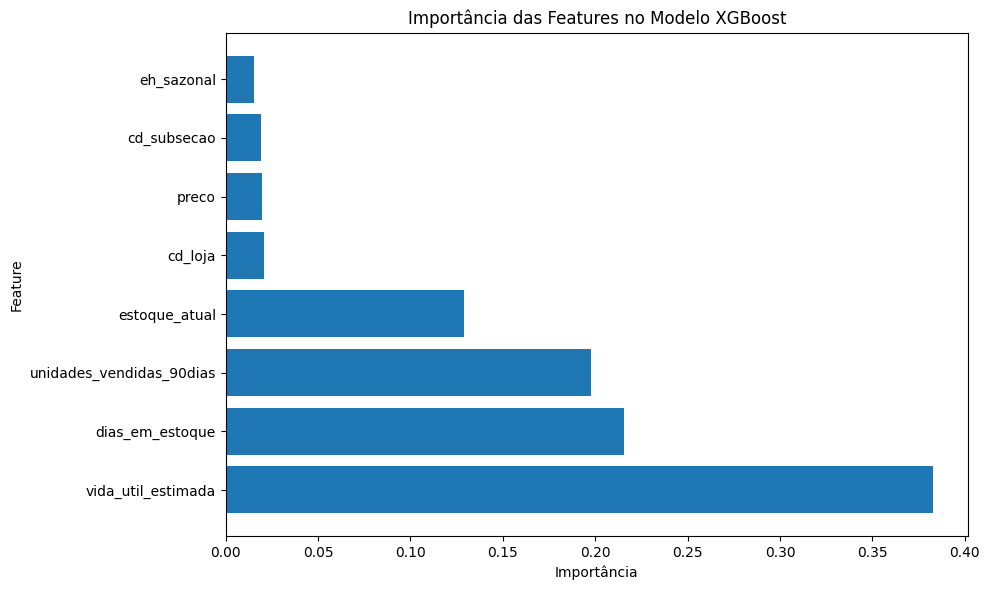

In [ ]:
# 3. Avaliar o modelo
avaliar_modelo(modelo_risco, X_teste, y_teste)

Neste bloco, aplicamos o modelo treinado a todos os produtos.

Calculamos a probabilidade de vencimento para cada item no estoque, também determinamos quantos dias restam até que uma ação seja necessária.

Para cada produto, o sistema recomenda a ação mais apropriada.

In [ ]:
# 4. Avaliar risco
df_resultado = avaliar_risco_estoque(df_preparado, modelo_risco)

Aqui visualizamos o resultado final da análise de risco

Mostramos uma amostra de 10 produtos com suas informações principais:

- Identificação do produto e seção

- Estoque atual e vida útil restante

- Probabilidade de vencimento calculada pelo modelo XGBoost

- Dias restantes para tomar ação

- Ação recomendada pelo sistema para cada produto

In [ ]:
# 5. Visualizar
df_resultado[['LM', 'nome_produto', 'secao', 'estoque_atual', 'vida_util_restante',
              'probabilidade_vencimento', 'dias_para_acao', 'acao_recomendada']].sample(10)

,LM,nome_produto,secao,estoque_atual,vida_util_restante,probabilidade_vencimento,dias_para_acao,acao_recomendada
52,90595511,Saco de Cimento CP II 50kg,MATERIAIS,27.0,17,0.339091,0,Redução imediata de preço 50%+
966,90236666,Bromélia,JARDIM,44.0,100,0.039121,60,Monitorar e reavaliar em 14 dias
3041,82290860,Palmeira Areca,JARDIM,61.0,-45,0.997364,0,Produto já vencido - descartar ou ação imediata
5460,85492288,Supercola Instantânea,PINTURA,49.0,-414,0.999057,0,Produto já vencido - descartar ou ação imediata
9124,88816965,Tinta Látex Cinza Urbano,PINTURA,47.0,-21,0.752464,0,Produto já vencido - descartar ou ação imediata
328,94514363,Bougainville,JARDIM,78.0,-42,0.995401,0,Produto já vencido - descartar ou ação imediata
4942,82109572,Saco de Cimento CP II 50kg,MATERIAIS,7.0,284,0.023536,60,Monitorar e reavaliar em 14 dias
324,88670178,Cola PVA Branca 1L,PINTURA,30.0,177,0.067859,60,Monitorar e reavaliar em 14 dias
4631,83203028,Bougainville,JARDIM,48.0,0,0.995357,0,Produto já vencido - descartar ou ação imediata
7491,95855701,Argila Expandida 10L,MATERIAIS,22.0,28,0.910984,0,Redução imediata de preço 50%+


Este bloco adiciona uma visualização avançada da performance do modelo.

A curva ROC (Receiver Operating Characteristic) mostra a relação entre
verdadeiros positivos e falsos positivos em diferentes limiares.

A área sob a curva (AUC) indica a capacidade do modelo de distinguir
entre produtos que vão vencer e produtos que não vão vencer.

Um valor de AUC mais próximo de 1 indica um modelo melhor.


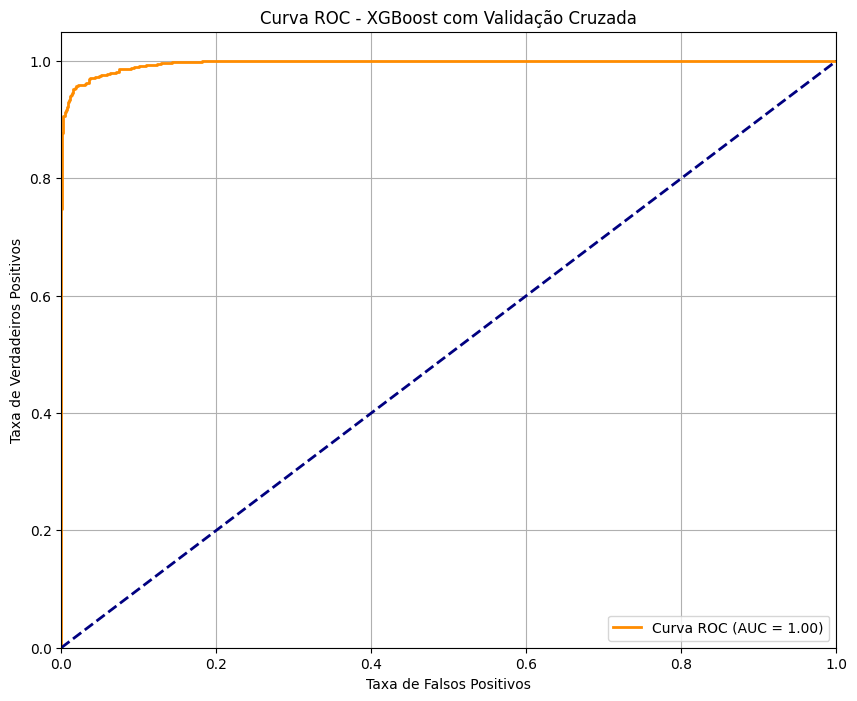

In [ ]:
# 6. Visualização adicional da performance do modelo
from sklearn.metrics import roc_curve, auc

# Calcular e plotar a curva ROC
y_scores = modelo_risco.predict_proba(X_teste)[:,1]
fpr, tpr, thresholds = roc_curve(y_teste, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - XGBoost com Validação Cruzada')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()